In [ ]:
下面我们开始尝试做图形的预处理。

图片旋转：
下面的代码，取自gnt-C.ipynb
http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate
    
    
    这个skimage： http://scikit-image.org/docs/dev/auto_examples/index.html
        
        感觉做图片的切分应该很合适。
        
        

../data/sandbox/03755
shape of images is:  (120, 64, 64)
sandbox:  120 531 [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
image_data:  [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


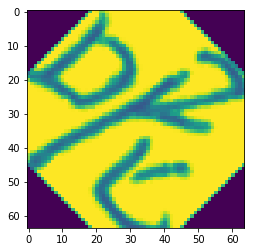

In [8]:
import os
import random
from PIL import *
from numpy import array

IMAGE_SIZE = 64
CHARSET_SIZE = 3755

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.transform import rotate

class DataIterator:
    def __init__(self, data_dir):
        # Set FLAGS.charset_size to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print(truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        image_rotated = [rotate(image, -45) for image in image_resized]
        self.images = [rgb2gray(item) for item in image_rotated]
        self.images = array(self.images)
        print ('shape of images is: ', self.images.shape)

    @property
    def size(self):
        return len(self.labels)
    
test_feeder = DataIterator(data_dir='../data/sandbox/')
print ('sandbox: ', test_feeder.size, test_feeder.labels[0], test_feeder.images[0])


# show image
import matplotlib.pyplot as plt
first_array=test_feeder.images[0]
image_data = first_array.reshape((IMAGE_SIZE, IMAGE_SIZE))
print ('image_data: ', image_data)


#Not sure you even have to do that if you just want to visualize it
#first_array=255*first_array
#first_array=first_array.astype("uint8")
plt.imshow(image_data)
#Actually displaying the plot if you are not in interactive mode
plt.show()

图片的亮度：
